In [ ]:
# import keras
# import requests as re
# from keras import datasets
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten
# from keras.layers import Conv2D, MaxPooling2D, Activation
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, datasets, callbacks, regularizers, utils, Model
from tensorflow_addons.optimizers import CyclicalLearningRate, ExponentialCyclicalLearningRate

In [ ]:
%pip install tensorflow-addons

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Get Data: Cifar10  ->  use  tf.keras.datasets.cifar10

(train_X, train_Y), (test_X, test_Y) = datasets.cifar10.load_data()
print("train_images shape: ", train_X.shape)   #(50000, 32, 32, 3)
print("train_labels shape: ", train_Y.shape)   #(50000, 1)


# Data Preprocessing  ->  normalize(between 0 and 1),  zero-centered(x_train - mean, x_test - mean),  onehot_transform
# normalize pixel values to be between 0 and 1
train_X_normal, test_X_normal = train_X.astype('float32')/255.0, test_X.astype('float32')/255.0


# zero-centered
mean = np.mean(train_X_normal, axis = 0)
train_X_normal -= mean
test_X_normal -= mean
    

# visualize 1 instance 
print(train_X_normal[0, :], test_X_normal[0, :])


# one_hot_encode transform
train_Y_onehot = to_categorical(train_Y, 10)
test_Y_onehot = to_categorical(test_Y, 10)
print("top10 train_labels: \n", train_Y_onehot[:10])

170500096/170498071 [==============================] - 4s 0us/step
train_images shape:  (50000, 32, 32, 3)
train_labels shape:  (50000, 1)
[[[-0.28121656 -0.2904184  -0.272762  ]
  [-0.3417282  -0.35075825 -0.3406073 ]
  [-0.31784582 -0.3460663  -0.35130537]
  ...
  [ 0.1056478  -0.016895   -0.095853  ]
  [ 0.08473122 -0.04199991 -0.117654  ]
  [ 0.06990451 -0.04499993 -0.11330768]]

 [[-0.44744533 -0.452138   -0.43672228]
  [-0.50723326 -0.52729446 -0.5116333 ]
  [-0.4400649  -0.4987352  -0.5141287 ]
  ...
  [-0.02761969 -0.18486139 -0.29765403]
  [-0.04051188 -0.20219544 -0.31568617]
  [-0.02806601 -0.1858215  -0.2880453 ]]

 [[-0.4106835  -0.43391442 -0.42843628]
  [-0.44202578 -0.49607033 -0.50595963]
  [-0.3155821  -0.41982794 -0.47637933]
  ...
  [-0.04396614 -0.1959193  -0.31096065]
  [-0.03369251 -0.19428387 -0.31006348]
  [-0.07682845 -0.23748371 -0.34205657]]

 ...

 [[ 0.31939682  0.17272711 -0.07115021]
  [ 0.2996532   0.11476886 -0.30501914]
  [ 0.29048917  0.14979655 -0.3

In [ ]:
# Plot train_image and prediction image

def plot_image_label_condition(images, labels, num, figsize = (12, 10), n_rc = (5, 5), compare_label_pred = False):
    plt.figure(figsize = figsize, tight_layout = True)
    n_rows, n_cols = n_rc
    for i in range(num):
        plt.subplot(n_rows, n_cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap = None)  
        title = class_names[labels[i][0]]
        if compare_label_pred == True:
            predict_name = " --> [ " + class_names[class_pred[i]] + " ]"
            title += predict_name
            # prediction incorrect 
            if class_names[class_pred[i]] != title:
                plt.xlabel('incorrect !', fontsize = 14, fontdict = {'color': 'red'})
        plt.title(title, fontsize = 14)
    plt.show()

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


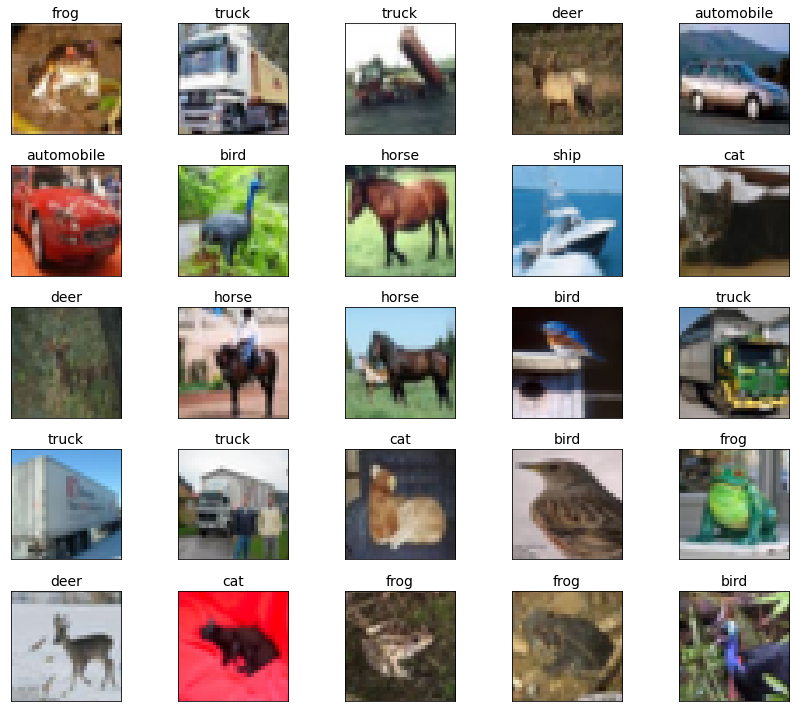

In [ ]:
# Set cifar10 class names
class_value = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num = [i for i in range(10)]

class_names = { key: class_value[key] for key in num }
print(class_names)

# Plot raw data 
plot_image_label_condition(train_X, train_Y, num = 25)  # figsize, nrows, ncols, num, compare_label_pred

In [ ]:
# General CNN 

# SGD: (learning_rate=0.01, momentum=0.0)
# Adam: (learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Try Deep CNN
def cnn_model():
    # weight_decay = 1e-3
    model = models.Sequential()

    # stage_1
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4), input_shape = (32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    # stage_2
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    # stage_3
    model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform', 
                            kernel_regularizer=regularizers.l2(1e-4)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.4))

    # stage_4
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = 'relu', kernel_initializer = 'he_uniform'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation = 'softmax'))

    # compile the model
    model.compile(loss = 'categorical_crossentropy',
                optimizer = 'adam', metrics= ['accuracy'])
        
    return model

In [ ]:
# Intermediate CNN

# Vgg16
def vgg16_model(activation = 'relu', decay = 1e-4, dropout = 0.5):   # lr_mode = one_cycle
    model = models.Sequential()

    # block_1
    model.add(layers.Conv2D(64, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same', input_shape = (32,32,3)))
    model.add(layers.Conv2D(64, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), strides = 2))

    # block_2
    model.add(layers.Conv2D(128, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(128, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), strides = 2))

    # block_3
    model.add(layers.Conv2D(256, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(256, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(256, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), strides = 2))

    # block_4
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), strides = 2))

    # block_5
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.Conv2D(512, (3,3), activation = alpha, kernel_regularizer = regularizers.L2(decay), 
                            padding = 'same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2,2), strides = 2))

    # classification block
    model.add(layers.Flatten())
    model.add(layers.Dense(2048, kernel_regularizer = regularizers.L2(decay), activation = alpha))   # 512
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(1024, kernel_regularizer = regularizers.L2(decay), activation = alpha))   # 256
    model.add(layers.Dropout(dropout))
    model.add(layers.Dense(10, activation = 'softmax'))

    # compile the model
    optimizer = tf.keras.optimizers.Adam(clipvalue = 0.1)  # learning_rate = lr_mode, clipvalue = 0.1

    model.compile(loss = 'categorical_crossentropy',
                optimizer = optimizer, metrics= ['accuracy'])
        
    return model

In [ ]:
# Advanced CNN 

# ResNet50 

def identity_block(X, f, filters, kernel_initializer = 'he_normal', kernel_regularizer = regularizers.L2(5e-4)):

    # input = X
    shortcut = X

    F1, F2, F3 = filters

    # first step
    X = layers.Conv2D(F1, (1, 1), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = 1)(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)
    X = layers.Activation('relu')(X)

    # second step
    X = layers.Conv2D(F2, (f, f), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = 1, padding = 'same')(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)
    X = layers.Activation('relu')(X)

    # third step
    X = layers.Conv2D(F3, (1, 1), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = 1)(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)

    # add shortcut to third step output X
    X = layers.Add()([X, shortcut])
    X = layers.Activation('relu')(X)

    return X

def convolutional_block(X, f, filters, kernel_initializer = 'he_normal', kernel_regularizer = regularizers.L2(5e-4), s = 2):
    
    # input = X
    shortcut = X

    F1, F2, F3 = filters

    # first step
    X = layers.Conv2D(F1, (1, 1), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = s)(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)
    X = layers.Activation('relu')(X)

    # second step
    X = layers.Conv2D(F2, (f, f), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = 1, padding = 'same')(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)
    X = layers.Activation('relu')(X)

    # third step
    X = layers.Conv2D(F3, (1, 1), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                      strides = 1)(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)

    # shortcut step
    shortcut = layers.Conv2D(F3, (1, 1), kernel_initializer = kernel_initializer, kernel_regularizer = kernel_regularizer, 
                             strides = s)(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)

    # add shortcut step output to third step output
    X = layers.Add()([X, shortcut])
    X = layers.Activation('relu')(X)

    return X

# onec_cycle: add argument -> (train_X = train_X)
def ResNet50(input_shape = (train_X.shape[1], train_X.shape[2], train_X.shape[3])):  
    
    # architecture: CONV2D -> Batch Norm -> ReLU -> MaxPool ---> 1. CONV_BLOCK -> ID_BLOCK * 2 ---> 2. CONV_BLOCK -> ID_BLOCK * 3 --->
    #               3. CONV_BLOCK -> ID_BLOCK * 5 ---> 4. CONV_BLOCK -> ID_BLOCK * 2 ---> AvgPool -> OUTPUT

    X_input = layers.Input(input_shape)

    # zero-padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # stage 1  
    X = layers.Conv2D(64, (7, 7), kernel_initializer = 'he_normal', strides = 2)(X)
    X = layers.BatchNormalization(axis = 1, momentum = 0.9, epsilon = 2e-5)(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides = 2)(X)

    # stage 2      (identity_block * 2)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, f = 3, filters = [64, 64, 256])
    X = identity_block(X, f = 3, filters = [64, 64, 256])

    # stage 3      (identity_block * 3)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])
    X = identity_block(X, f = 3, filters = [128, 128, 512])

    # stage 4      (identity_block * 5)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])
    X = identity_block(X, f = 3, filters = [256, 256, 1024])

    # stage 5      (identity_block * 2)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s= 2)
    X = identity_block(X, f = 3, filters = [256, 256, 2048])
    X = identity_block(X, f = 3, filters = [256, 256, 2048])

    # AvgPooling  AveragePooling2D((2, 2), padding = 'same')  or GlobalAveragePooling2D()
    X = layers.GlobalAveragePooling2D()(X)

    # Flatten() -> Softmax -> output
    X = layers.Flatten()(X)
    X = layers.Dense(10, kernel_regularizer = regularizers.L2(0.0005), activation = 'softmax')(X)

    # create model
    model = Model(inputs = X_input, outputs = X)

    # learning schedule each step -> one_cycle
    # def scale_fn(x):
    #     return 1 / (2.0**(x - 1)) 

    # one_cycle = CyclicalLearningRate(initial_learning_rate = 1e-3,    # 0.001 
    #                              maximal_learning_rate = 0.5e-2,   # 0.005  or  0.006 
    #                              step_size = math.ceil(8 * len(train_X) / batch_size),   # step_size = (2 ~ 10) * epoch, 8 is good for cifar10
    #                              scale_fn = lambda x: 1 / (2.0**(x - 1)),  # triangular2
    #                              scale_mode = 'cycle')

    # compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01, clipvalue = 0.1)   # learning_rate = 0.01, decay = 1e-4, clipvalue = 0.1
    
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer = optimizer, metrics = ['accuracy'])

    return model

In [ ]:
# # Advanced CNN - ResNet9 (subclassing)

# # (Cifar10 using ResNet of Kaiming He et al.)
# # ++++++++++++++++++++++++++++++++++++++++++++++ #

# '''
# Residual_Bottleneck: {(bn - relu - conv 1x1) + (bn - relu - conv 3x3) + (bn - relu - conv 1x1)} + shortcut(input) => output
#                 ###  reduce the spatial size --> apply a Conv2D layer to the shortcut  ###

# Hyperparameters: regularizer_l2(0.0001 ~ 0.0005(best)), bn_eps: 2e-5, bn_mom: 0.9, stride: 1 or 2, 
#                  filters: f = [64, 64, 128, 256], stages = (9, 9, 9)
# '''

# # ResNet9 - Subclassing 

# class Residual_bottleneck(layers.Layer):
#     def __init__(self, f, stride = 1, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, reduce = False, **kwargs):
#         super(Residual_bottleneck, self).__init__(**kwargs)

#         self.stride = stride
#         # self.inputs = inputs

#         # step 1. (bn - relu - conv 1x1)
#         self.bn_1 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_1 = layers.Activation("relu")
#         self.conv_1 = layers.Conv2D(int(f * 0.25), (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))

#         # step 1. (bn - relu - conv 3x3)
#         self.bn_2 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_2 = layers.Activation("relu")
#         self.conv_2 = layers.Conv2D(int(f * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, 
                                    # kernel_regularizer = regularizers.l2(reg))

#         # step 1. (bn - relu - conv 1x1)
#         self.bn_3 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_3 = layers.Activation("relu")
#         self.conv_3 = layers.Conv2D(f, (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))

#         # conv skip
#         self.bn_skip = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.act_skip = layers.Activation("relu")
#         self.conv_skip = layers.Conv2D(f, (1, 1), strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(reg))
       
#         # reduce the spatial size
#         # self.reduce = reduce

#         # append to residual_block
#         self.residual_block = [self.bn_1, self.act_1, self.conv_1,
#                                self.bn_2, self.act_2, self.conv_2,
#                                self.bn_3, self.act_3, self.conv_3]

#         # for i in range(len(total_step)):
#         #     self.residual_block = []
#         #     self.residual_block.append(total_step[i])

#         # self.skip_block = []
#         # if stride == 2:
#         # if self.reduce:
#         self.skip_block = [self.bn_skip, self.act_skip, self.conv_skip]
      
#     def call(self, inputs):
#         x = inputs
        
#         for step in self.residual_block:
#             x = step(x)

#         shortcut = inputs
#         # apply a Conv2D layer to the shortcut
#         if self.stride == 2:
#             for skip in self.skip_block:
#                 shortcut = skip(shortcut)    #  filters ≠ int(filters * 0.25)  =>  self.conv_skip

#         output = layers.add([x, shortcut])

#         return output

#     # def get_config(self):
#     #     base_config = super().get_config()
#     #     base_config.update({
#     #         'f': self.f, 
#     #         'stride': self.stride,
#     #         'bn_eps': self.bn_eps,
#     #         'bn_mom': self.bn_mom,
#     #     })
#     #     return base_config

# class ResNet9(Model):
#     def __init__(self, inputs, filters, stages, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, pooling_size = (8, 8), **kwargs):
#         super(ResNet9, self).__init__(**kwargs)

#         self.filters = filters
#         self.stages = stages
#         self.bn_eps = bn_eps
#         self.bn_mom = bn_mom
#         self.reg = reg

#         self.inputs = layers.Input(inputs)

#         self.bn = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)
#         self.conv2d = layers.Conv2D(filters[0], (3, 3), padding = 'same', use_bias = False, 
                                    # kernel_regularizer = regularizers.L2(reg))
        
#         self.act = layers.Activation('relu')
#         self.avg_pool2d = layers.AveragePooling2D(pooling_size)

#         self.flatten = layers.Flatten()
#         self.dense = layers.Dense(10, kernel_regularizer = regularizers.L2(reg))

#     def call(self, inputs):

#         # hint:
#         # stage[0] -> filters[1] * 9 (stride = 1)
#         # stage[1] -> filters[2] * 1 (stride = 2) + filters[2] * 8 (stride = 1)
#         # stage[2] -> filters[3] * 1 (stride = 3) + filters[3] * 8 (stride = 1)
#         # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #

#         x = self.bn(self.inputs)
#         x = self.conv2d(x)

#         # for s in range(0, len(self.stages)):
#         #     stride = 1 if s == 0 else 2
#         #     x = Residual_bottleneck(self.filters[s + 1], stride, bn_eps = self.bn_eps, 
#         #                         bn_mom = self.bn_mom, reg = self.reg, reduce = True)(x)
#         #     for i in range(0, self.stages[s] - 1):
#         #         x = Residual_bottleneck(self.filters[s + 1], (1, 1), bn_eps = self.bn_eps,
#         #                             bn_mom = self.bn_mom, reg = self.reg)(x)

#         # loop over the number of stages
#         prev_filters = self.filters[1]
#         s1, s2, s3 = self.stages

#         for i in [self.filters[1]] * s1 + [self.filters[2]] * s2 + [self.filters[3]] * s3:
#             stride = 1 if i == prev_filters else 2
#             x = Residual_bottleneck(i, stride, bn_eps = self.bn_eps, bn_mom = self.bn_mom)(x)
#             prev_filters = i

#         # bn -> act -> pool
#         x = self.bn(x)
#         x = self.act(x)
#         x = self.avg_pool2D(x)

#         # flatten -> dense -> softmax
#         x = self.flatten()(x)
#         x = self.dense(x)
#         x = self.act('softmax')(x)

#         return x

# compile the model
print("[INFO] Compiling Model...")
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99

# model = ResNet9((32, 32, 3), (64, 64, 128, 256), (9, 9, 9), reg = 0.0005)

# model.compile(optimizer = optimizer, 
#               loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
# Change model: 

# Model: cnn_model(), vgg16_model(), ResNet50(input_shape)
# model = ResNet50()  # @param {type: "string"}  

use_subclass = True   # @param ["False", "True"] {type: "raw"}

# Subclassing not have model.summary()
if use_subclass == False:
    print(model.summary())

In [ ]:
# Data Augmentation

batch_size = 128    # @param [32, 64, 128, 256]
steps = int(train_X.shape[0] / batch_size)   # ex: 50000 / batch_size(128) = 390

data_augment = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, 
                                  horizontal_flip = True)   # rotation_range = 10
data_augment.fit(train_X_norm)
augment_train = data_augment.flow(train_X_norm, train_Y_onehot, batch_size = batch_size)

In [ ]:
# Piecewise_constant Scheduling:

def piecewise_constant_lr(epochs):
    lr = 0.5e-4          # 0.0005 or 0.001
    if epochs < 15:      # resnet -> 50 -> 70
        return lr
    elif epochs < 25:
        lr *= 2
        return lr
    elif epochs < 30:
        lr *= 0.5
        return lr
    else:
        lr *= 0.1
        return lr

In [ ]:
# Learning rate decay Scheduling for ResNet9

def lr_decay(epoch):
    base_lr = 1e-1   # ResNet9: 0.1
    pow = 1.0
    lr_decay = base_lr * (1 - epoch/Epochs)**pow

    return lr_decay

In [ ]:
# OneCycle Scheduling: 

# In the paper Leslie Smith states:
# Experiments show that replacing each step of a constant learning rate with at least 3 cycles trains the network weights
# most of the way and running for 4 or more cycles will achieve even better performance.

# CLR Policy:
# +++++++++++++++++++ #
'''
   triangular:   lambda x: 1.0
   triangular2:  lambda x: 1 / (2.0**(x - 1))
   exp_range:    lambda x: gamma ** x    # gamma = 0.99994
'''

# Cifar10 with (onecycle): triangular2 policy 
# ++++++++++++++++++++++++++++++++++++++++++++++ #
'''
   step_size = 2000 -> lr_base: 0.001,   lr_max: 0.005
   step_size = 1000 -> lr_base: 0.0001,  lr_max: 0.0005    => lr = step_size(2000) / 10
   step_size = 500  -> lr_base: 0.00001, lr_max: 0.00005   => lr = step_size(2000) / 10
'''

# 1cycle algorithm:
# +++++++++++++++++++ #
'''
   cycle = tf.floor(1 + epoch / (2 * step_size))
   x = tf.abs(epoch / step_size - 2 * cycle + 1)
   lr = initial_learning_rate + (maximal_learning_rate - initial_learning_rate) * tf.maximum(tf.cast(0, dtype), 
                                                                                            (1 - x)) * scale_fn(cycle)
'''

# def scale_fn(x):
#         return 1 / (2.0**(x - 1))  # triangular2 


# each step update learning_rate
one_cycle = CyclicalLearningRate(initial_learning_rate = 0.001 ,   # 0.001 -> 1e-3
                                 maximal_learning_rate = 0.01,   # 0.005  or  0.006  or  0.3
                                 step_size = math.ceil(3 * len(train_X) / batch_size),   # step_size = (2 ~ 10) * epoch, 8 is good for cifar10
                                 scale_fn = lambda x: 1 / (2.0**(x - 1)),  # triangular2         
                                 scale_mode = 'cycle')  

one_cycle_exp = ExponentialCyclicalLearningRate(initial_learning_rate = 1e-3,
                                                maximal_learning_rate = 0.5e-2, 
                                                step_size = math.ceil(8 * len(train_X) / batch_size),
                                                gamma = 0.99994,    # fn =  lambda x: gamma ** x,  exp_range,  gamma = 0.96
                                                scale_mode = 'cycle')

In [ ]:
# ResNet9 - Subclassing 

class ResNet9:
    def Residual_bottleneck(inputs, f, stride = 1, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005):
        
        # step 1. (bn - relu - conv 1x1)
        bn_1 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(inputs)
        act_1 = layers.Activation("relu")(bn_1)
        conv_1 = layers.Conv2D(int(f * 0.25), (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_1)

        # step 2. (bn - relu - conv 3x3)
        bn_2 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_1)
        act_2 = layers.Activation("relu")(bn_1)
        conv_2 = layers.Conv2D(int(f * 0.25), (3, 3), strides = stride, padding = "same", use_bias = False, 
                               kernel_regularizer = regularizers.l2(reg))(act_2)

        # step 3. (bn - relu - conv 1x1)
        bn_3 = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(conv_2)
        act_3 = layers.Activation("relu")(bn_3)
        conv_3 = layers.Conv2D(f, (1, 1), use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_3)

        # conv skip
        conv_skip = layers.Conv2D(f, (1, 1), strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(reg))(act_1)

        shortcut = inputs
        if stride == 2:
            shortcut = conv_skip
      
        output = layers.add([conv_3, shortcut])

        return output

    def call(inputs, filters, stages, bn_eps = 2e-5, bn_mom = 0.9, reg = 0.0005, pooling_size = (8, 8)):

        input = layers.Input(inputs)
        x = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(input)
        x = layers.Conv2D(filters[0], (3, 3), padding = 'same', use_bias = False, kernel_regularizer = regularizers.L2(reg))(x)
        
        # hint:
        # stage[0] -> filters[1] * 9 (stride = 1)
        # stage[1] -> filters[2] * 1 (stride = 2) + filters[2] * 8 (stride = 1)
        # stage[2] -> filters[3] * 1 (stride = 2) + filters[3] * 8 (stride = 1)
        # ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ #
        
        # for s in range(0, len(stages)):
        #     stride = 1 if s == 0 else 2
        #     x = ResNet9.Residual_bottleneck(x, filters[s + 1], stride, bn_eps = bn_eps, 
        #                                     bn_mom = bn_mom, reduce = True)
        #     for i in range(0, stages[s] - 1):
        #         x = ResNet9.Residual_bottleneck(x, filters[s + 1], (1, 1), bn_eps = bn_eps,
        #                                         bn_mom = bn_mom)

        # loop over the number of stages
        prev_filters = filters[1]
        s1, s2, s3 = stages

        for i in [filters[1]] * s1 + [filters[2]] * s2 + [filters[3]] * s3:
            stride = 1 if i == prev_filters else 2
            x = ResNet9.Residual_bottleneck(x, i, stride, bn_eps = bn_eps, bn_mom = bn_mom)
            prev_filters = i

        # bn -> act -> pool
        x = layers.BatchNormalization(epsilon = bn_eps, momentum = bn_mom)(x)
        x = layers.Activation('relu')(x)
        x = layers.AveragePooling2D(pooling_size)(x)

        # flatten -> dense -> softmax
        x = layers.Flatten()(x)
        x = layers.Dense(10, kernel_regularizer = regularizers.L2(reg))(x)
        x = layers.Activation('softmax')(x)

        model = Model(input, x)

        return model

# compile the model
print("[INFO] Compiling Model...")
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, clipvalue = 0.1)  # default: lr = 0.01, mom = 0.99  # decay

model = ResNet9.call((32, 32, 3), (64, 64, 128, 256), (9, 9, 9), reg = 0.0005)

model.compile(optimizer = optimizer, 
              loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
from tensorflow.keras import backend as K

class CyclicalLR(callbacks.Callback):
    def __init__(self, init_lr, max_lr, step_size, gamma = 0.99994, mode = 'triangular2'):
        super(CyclicalLR, self).__init__()
        self.init_lr, self.max_lr = init_lr, max_lr
        self.step_size = step_size
        self.gamma = gamma
        self.mode = mode

        self.cycle_iter = 0
        self.cycle_state = False
        self.reset() 

        if self.mode == 'triangular2':
            self.scale_fn = lambda x: 1 / (2.0**(x - 1))
            self.cycle_state = True
        elif self.mode == 'exp_range':
            self.scale_fn = lambda x: gamma ** x
            self.cycle_state = True
        elif self.mode == 'triangular':
            self.scale_fn = lambda x: 1

    def reset(self):
        self.cycle_iter = 0

    def cycle_lr(self):
        cycle = tf.floor(1 + self.cycle_iter / (2 * self.step_size))
        x = tf.abs(self.cycle_iter / self.step_size - 2 * cycle + 1)
        if self.cycle_state == True:
            return self.init_lr + (self.max_lr - self.init_lr) * tf.maximum(tf.cast(0, tf.float32), (1 - x)) * self.scale_fn(cycle)
        else:
            return self.init_lr + (self.max_lr - self.init_lr) * tf.maximum(tf.cast(0, tf.float32), (1 - x)) * self.scale_fn()

    def on_train_begin(self, logs = None):

        if self.cycle_iter == 0:
            K.set_value(self.model.optimizer.lr, self.init_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.cycle_lr())

    def on_batch_end(self, epoch, logs = None):

        self.cycle_iter += 1
        K.set_value(self.model.optimizer.lr, self.cycle_lr())

    def on_epoch_end(self, epoch, logs = None):

        logs_ratio = logs['val_loss'] / logs['loss']
        print(f'\nval/train_ratio: {logs_ratio:.2f}')

In [ ]:
# from tensorflow.keras import backend as K

# class CyclicLR(callbacks.Callback):
#     def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
#                  gamma=1., scale_fn=None, scale_mode='cycle'):
#         super(CyclicLR, self).__init__()

#         self.base_lr = base_lr
#         self.max_lr = max_lr
#         self.step_size = step_size
#         self.mode = mode
#         self.gamma = gamma
#         if scale_fn == None:
#             if self.mode == 'triangular':
#                 self.scale_fn = lambda x: 1.
#                 self.scale_mode = 'cycle'
#             elif self.mode == 'triangular2':
#                 self.scale_fn = lambda x: 1/(2.**(x-1))
#                 self.scale_mode = 'cycle'
#             elif self.mode == 'exp_range':
#                 self.scale_fn = lambda x: gamma**(x)
#                 self.scale_mode = 'iterations'
#         else:
#             self.scale_fn = scale_fn
#             self.scale_mode = scale_mode
#         self.clr_iterations = 0.
#         self.trn_iterations = 0.
#         self.history = {}

#         self._reset()

#     def _reset(self, new_base_lr=None, new_max_lr=None,
#                new_step_size=None):
#         """Resets cycle iterations.
#         Optional boundary/step size adjustment.
#         """
#         if new_base_lr != None:
#             self.base_lr = new_base_lr
#         if new_max_lr != None:
#             self.max_lr = new_max_lr
#         if new_step_size != None:
#             self.step_size = new_step_size
#         self.clr_iterations = 0.
        
#     def clr(self):
#         cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
#         x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
#         if self.scale_mode == 'cycle':
#             return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
#         else:
#             return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
#     def on_train_begin(self, logs={}):
#         logs = logs or {}

#         if self.clr_iterations == 0:
#             K.set_value(self.model.optimizer.lr, self.base_lr)
#         else:
#             K.set_value(self.model.optimizer.lr, self.clr())        
            
#     def on_batch_end(self, epoch, logs=None):
        
#         logs = logs or {}
#         self.trn_iterations += 1
#         self.clr_iterations += 1

#         self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
#         self.history.setdefault('iterations', []).append(self.trn_iterations)

#         for k, v in logs.items():
#             self.history.setdefault(k, []).append(v)
        
#         K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
import os 

DRIVE = '/content/drive/MyDrive/'

ML_PATH = "大伯 - ML_Code/"

if os.path.isdir(os.path.join(DRIVE, 'Colab Notebooks/')):
    MODEL_PATH = os.path.join(DRIVE, 'Colab Notebooks/', ML_PATH)   # drive_1
else:
    MODEL_PATH = os.path.join(DRIVE, ML_PATH)                       # drive_2

os.listdir(MODEL_PATH)

In [ ]:
# Golab GPU devices status

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
! nvidia-smi 

Num GPUs Available:  0
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# Reload the best_weights to evaluate  or  add more epochs to train

# best_weights_path = os.path.join(model_path, "best_cifar10_weights.h5")
# model = models.load_model(best_weights_path)

In [ ]:
# Train the model

# base_deep_cnn -> 100 epochs, test_acc: 0.86

# vgg16 -> 70 epochs, test_acc: 0.87 ~ 0.88
# vgg16 + performance_scheduling -> 60 epochs, test_acc: 0.8909
# vgg16 + piecewise_constant_scheduling(<15 -> lr, <25 -> lr*=0.5, >25 -> lr*=0.1) + 128 batch_size -> 35 ~ 40 epochs, test_acc: 0.8854
# vgg16 + onecycle + 32 batch_size -> 70 epochs, test_acc: 0.8701 ; 90 epochs, test_acc: 0.8704 
                                    # 100 epochs, test_acc: 0.8782 ; 120 epochs, test_acc: 0.8888
# vgg16 + onecycle_exp + 32 batch_size -> 80 epochs, test_acc: 0.8787, 100 epochs, test_acc: 0.8850

# ResNet50 -> 60 epochs, train_acc: 0.8740, val_acc: 0.8003, test_acc: 0.8151
            # 84 epochs, train_acc: 0.8944, val_acc: 0.8178 
# ResNet50 + onecycle(max_lr = 0.12) + 64 batch_size -> 60 epochs, test_acc: 0.8258
# ResNet50 + onecycle(base_lr = 0.001, max_lr = 0.01) + 64 batch_size -> 80 epochs, test_acc: 0.8257
                                                                      # 100 epochs, test_acc: 0.8303

Epochs = 100   # 60 
Patience = 30
best_weights_path = os.path.join(MODEL_PATH, "best_cifar10_weights.h5")


# Learning_rate_decay
lr_decay = callbacks.LearningRateScheduler(lr_decay)


# OneCycle Scheduling -> one_cycle, one_cycle_exp
# +++++++++++++++++++++++++++++++++++++++++++++++++ #
''' init_lr = 0.001
    max_lr = 0.1 ~ 0.3  or  0.006
    step_size = (2 ~ 10) * epoch, 8 is good for cifar10 . 
'''
# one_cycle_scheduler = callbacks.LearningRateScheduler(one_cycle)
# one_cycle = CyclicLR(max_lr = 0.3, step_size = math.ceil(8 * len(train_X) / batch_size), mode = 'triangular2')
# one_cycle = CyclicalLR(init_lr = 0.001, max_lr = 0.1, step_size = math.ceil(8 * len(train_X) / batch_size),
                    #    mode = 'triangular2')    # gamma = 0.99994, mode = 'triangular', 'triangular2', 'exp_range'

# Piecewise_constant Scheduling
# piecewise_scheduler = callbacks.LearningRateScheduler(piecewise_constant_lr)


# Performance Scheduling
# performance_scheduler = callbacks.ReduceLROnPlateau(factor = 0.3, patience = 5, min_lr = 0.5e-6)   # factor = 0.3


# callbacks
check_point = callbacks.ModelCheckpoint(best_weights_path, save_best_only = True)   # default_param: monitor = 'val_loss'
early_stop = callbacks.EarlyStopping(patience = Patience, restore_best_weights = True)
call_backs = [check_point, early_stop, lr_decay] 


# model fit
history = model.fit(augment_train, steps_per_epoch = steps, epochs = Epochs, verbose = 1,
                   validation_data = (test_X_norm, test_Y_onehot), callbacks = call_backs)    # initial_epoch = 0

# restore the best model
model = models.load_model(best_weights_path)  

ValueError: ignored

In [ ]:
test_loss, test_acc = model.evaluate(test_X_norm, test_Y_onehot, verbose=2)

print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

313/313 - 4s - loss: 0.5660 - accuracy: 0.8895
test_loss: 0.5660
test_acc: 0.8895


NameError: ignored

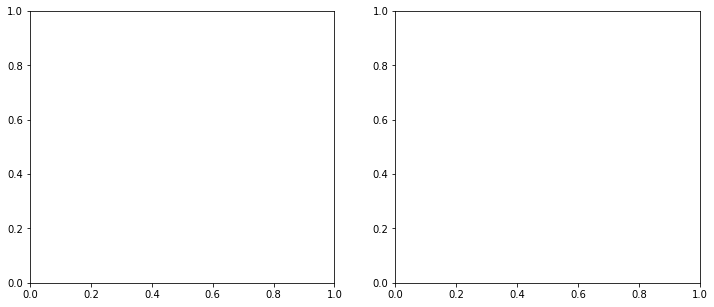

In [ ]:
# Evaluate the model

acc_loss_fig = 'ResNet9_acc_fig'    # Vgg16_acc_0.89_fig

def plot_model_pred_curves(figsize)
    fig, ax = plt.subplots(ncols = 2, sharex = True, figsize = figsize)

    for i in range(2):
        plt.axes(ax[i])
        if i == 0:
            acc_loss, val_acc_loss, ylim = ('accuracy', 'val_accuracy', 1)
        if i == 1:
            loss_ylim = np.ceil(np.maximum(np.max(history.history['loss']), np.max(history.history['val_loss'])))
            acc_loss, val_acc_loss, ylim = ('loss', 'val_loss', loss_ylim)

        plt.plot(history.history[acc_loss], label = acc_loss)
        plt.plot(history.history[val_acc_loss], "g--", label = val_acc_loss)
        plt.xlabel('epoch', fontsize = 14)
        plt.ylabel(acc_loss, fontsize = 14)
        plt.ylim(0, ylim)
        plt.grid(True)
        plt.legend(loc='upper left', fontsize = 12)
        plt.tight_layout()
    plt.show()

    # save figure
    fig.savefig(MODEL_PATH + acc_loss_fig, format = 'png', dpi = 300)   # model_path = os.path.join(os.getcwd(), cifar_path)
    print('save figure: ', acc_loss_fig)

plot_model_pred_curves(figsize = (12, 5))

# print test_loss, test_acc
test_loss, test_acc = model.evaluate(test_X_norm, test_Y_onehot, verbose=2)

print("predict test:")
print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

[[1.4828264e-06 2.5814673e-08 3.6457739e-05 9.9368542e-01 2.7448137e-05
  6.1881533e-03 5.2268992e-05 4.5920165e-06 1.3260494e-06 2.6798073e-06]]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 3 2 4 0 9 6 6 5 3 5 9 3 4
 1 9 5 4 6 5 6 0 9 3 9 7 6]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


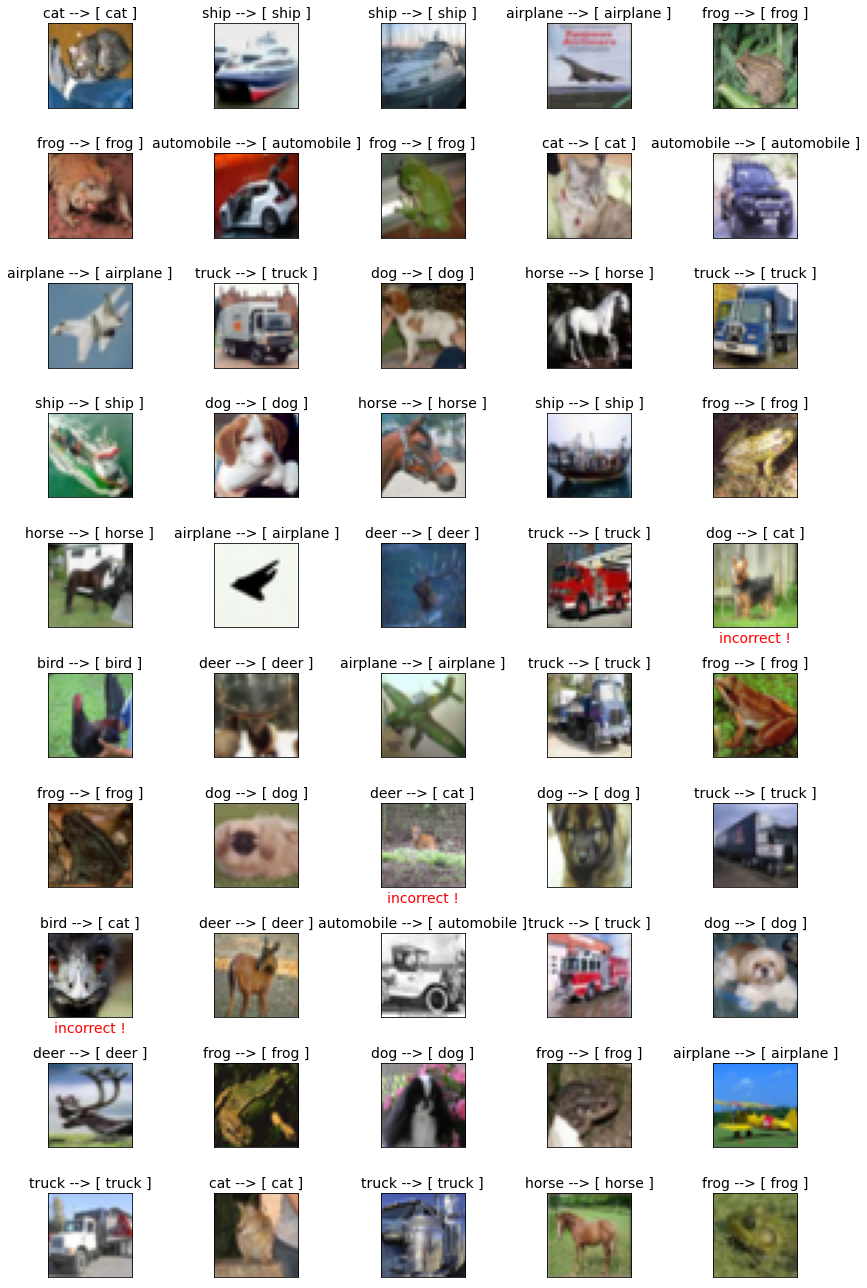

In [ ]:
# Plot predicted Correct and Error images

def plot_predicted_images(api = "Sequantial api", max_num = 25):
    if api == "Functional api":
        y_prob = model.predict(test_X_norm)
        print("instance 1 prediction: ", y_prob[:1])

        class_pred = y_prob.argmax(axis = -1)
        print(f"top {max_num} classes: ", class_pred[:max_num])

    elif api == "Sequantial api":
        class_pred = model.predict_classes(test_X_norm)
        print("prediction_class: ", class_pred[:max_num])

    plot_image_label_condition(test_X, test_Y, num = max_num, True)  # compare_label_pred = False

plot_predicted_images(api = "Funtional api", max_num = 50)

In [ ]:
# Save configure

model_name = 'cifar10_ResNet9'     # cifar10_ResNet50, cifar10_vgg_16, cifar10_cnn, cifar10_ResNet50_onecycle
model_dir = 'model_weights/'       

def save_model(model_name, model_dir, model_path):     # model_path = os.path.join(os.getcwd(), cifar_path)
    model_json = model.to_json()

    with open(model_path + model_dir + model_name + ".config","w") as json_file:
        json_file.write(model_json)
    print("save " + model_name + ".config")

    model.save_weights(model_path + model_dir + model_name + ".h5")
    print("save " + model_name + ".h5")

save_model(model_name, model_dir, MODEL_PATH)

save cifar10_vgg_16_performance_lr.config
save cifar10_vgg_16_performance_lr.h5


In [ ]:
# Load model

def load_model(model_name, model_dir, model_path):      # model_path = os.path.join(os.getcwd(), cifar_path)
    json_file = open(model_path + model_dir + model_name + ".config", "r")
    loaded_model_json = json_file.read()
    json_file.close()

    loaded_model = models.model_from_json(loaded_model_json)
    loaded_model.load_weights(model_path + model_dir + model_name + ".h5")
    print("loaded model configure & weights")

    return loaded_model

loaded_model = load_model(model_name, model_dir, MODEL_PATH)

loaded model configure & weights


In [ ]:
# Re Compile & Evaluate

loaded_model.compile(optimizer = 'adam',
                     loss = 'categorical_crossentropy', metrics = ['accuracy'])  # optimizer = 'adam', 'SGD' or etc.

test_loss, test_acc = loaded_model.evaluate(test_X_normal, test_Y_onehot, verbose=2)

print(f'test_loss: {test_loss:.4f}')
print(f'test_acc: {test_acc:.4f}')

313/313 - 6s - loss: 0.3923 - accuracy: 0.8909
test_loss: 0.3923
test_acc: 0.8909
